# Importing Python libraries and functions

In [1]:
import time
start_time = time.time()
import os
import numpy as np
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import adam
from keras import models
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time 
import progressbar
from tqdm.notebook import tqdm_notebook
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
os.getcwd()

'C:\\Users\\User\\Desktop\\4th_year_AMLS\\AMLS_19-20_ChinYangTan_16053203\\Project_AMLS_19-20_16053203\\B2'

# Data Preprocessing

In [3]:
df = pd.read_csv('../Dataset_original_AMLS_19-20/cartoon_set/labels.csv', sep = '\t')
df = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[2]])
df['eye_color'] = df['eye_color'].apply(str)
df

,eye_color,file_name
0,1,0.png
1,2,1.png
2,2,2.png
3,2,3.png
4,0,4.png
...,...,...
9995,3,9995.png
9996,0,9996.png
9997,1,9997.png
9998,0,9998.png


In [4]:
img = ('../Dataset_original_AMLS_19-20/cartoon_set/img')
training, testing = np.split(df.sample(frac=1), [int(0.9*len(df)),]) #splitting at n-array

In [5]:
# set up data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.2,
    horizontal_flip=True,
    vertical_flip=True   
)

# Get batches of training dataset from the dataframe
print("Training Dataset Preparation: ")
train_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "eye_color",
        class_mode = 'categorical', target_size = (64,64),
        batch_size = 128, subset = 'training') 
   
# Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparation: ")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "eye_color",
        class_mode = 'categorical', target_size = (64,64),
        batch_size = 128, subset = 'validation')

Training Dataset Preparation: 
Found 7200 validated image filenames belonging to 5 classes.

Validation Dataset Preparation: 
Found 1800 validated image filenames belonging to 5 classes.


# Implementing CNN

In [20]:
#*put under a def*
# starting point 
my_model= models.Sequential()

# Add first convolutional block
my_model.add(Conv2D(16, (3, 3), activation='relu', padding='same',input_shape=(64,64,3))) 
my_model.add(MaxPooling2D((2, 2), padding='same'))
# second block
my_model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
my_model.add(MaxPooling2D((2, 2), padding='same'))
# third block
my_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
my_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))

# make predictions
my_model.add(Flatten())
my_model.add(Dense(5, activation='softmax'))
# Show a summary of the model. Displaying the number of trainable parameters
my_model.summary()
my_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)        

In [21]:
#*copy to main function*
history = my_model.fit_generator(
                                train_generator,
                                epochs=13,
                                steps_per_epoch=train_generator.samples // train_generator.batch_size,
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // validation_generator.batch_size
                                )

Epoch 1/13
56/56 [==============================] - 72s 1s/step - loss: 1.5606 - accuracy: 0.2648 - val_loss: 1.3358 - val_accuracy: 0.4185
Epoch 2/13
56/56 [==============================] - 59s 1s/step - loss: 1.2298 - accuracy: 0.4721 - val_loss: 1.0931 - val_accuracy: 0.5933
Epoch 3/13
56/56 [==============================] - 54s 958ms/step - loss: 0.9776 - accuracy: 0.6415 - val_loss: 0.8912 - val_accuracy: 0.6226
Epoch 4/13
56/56 [==============================] - 96s 2s/step - loss: 0.7759 - accuracy: 0.7197 - val_loss: 0.6437 - val_accuracy: 0.7667
Epoch 5/13
56/56 [==============================] - 103s 2s/step - loss: 0.5730 - accuracy: 0.7999 - val_loss: 0.6578 - val_accuracy: 0.8092
Epoch 6/13
56/56 [==============================] - 100s 2s/step - loss: 0.4871 - accuracy: 0.8165 - val_loss: 0.4065 - val_accuracy: 0.8002
Epoch 7/13
56/56 [==============================] - 91s 2s/step - loss: 0.4370 - accuracy: 0.8281 - val_loss: 0.5367 - val_accuracy: 0.8272
Epoch 8/13
56/5

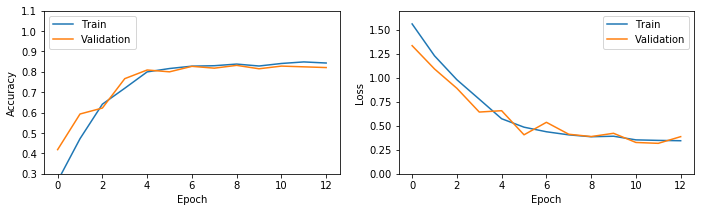

In [22]:
plt.figure(figsize=(18, 3))

plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.3,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(132)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,1.7])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.savefig("Custom_Keras_ODSC.png", dpi=300)

In [23]:
from keras.models import load_model

modelFile = 'my_CNN.h5'

my_model.save(modelFile)

# Evaluation of model

In [24]:
# extracting new test dataset
df2 = pd.read_csv('../Dataset_test_AMLS_19-20/cartoon_set_test/labels.csv', sep = '\t')
df2 = df2.drop(columns = [df2.columns[0]]).drop(columns = [df2.columns[2]])
df2['eye_color'] = df2['eye_color'].apply(str)
df2

,eye_color,file_name
0,2,0.png
1,1,1.png
2,0,2.png
3,0,3.png
4,3,4.png
...,...,...
2495,4,2495.png
2496,2,2496.png
2497,2,2497.png
2498,4,2498.png


In [25]:
# image path for new test images
img = ('../Dataset_test_AMLS_19-20/cartoon_set_test/img')

In [26]:
# initial test dataset from splitting
# saved_model = load_model(modelFile)
# test_generator = data_generator.flow_from_dataframe(
#         dataframe = testing, directory = img,
#         x_col = "file_name", y_col = "eye_color",
#         batch_size=1,
#         class_mode='categorical', target_size=(64, 64),
#         shuffle=False)
# test_steps = test_generator.samples
# print(test_steps)

saved_model = load_model(modelFile)
test_generator = data_generator.flow_from_dataframe(
        dataframe = df2, directory = img,
        x_col = "file_name", y_col = "eye_color",
        batch_size=1,
        class_mode='categorical', target_size=(64, 64),
        shuffle=False)
test_steps = test_generator.samples
print(test_steps)

Found 2500 validated image filenames belonging to 5 classes.
2500


In [27]:
# printing training loss and accuracy
tr_sc = saved_model.evaluate_generator(train_generator, steps = validation_generator.samples // 32, verbose=1)

print('Train loss: '+ str(tr_sc[0]))
print('Train Accuracy: '+ str(tr_sc[1]))

56/56 [==============================] - 29s 512ms/step
Train loss: 0.300576388835907
Train Accuracy: 0.8487723469734192


In [28]:
# printing validation loss and accuracy
val_sc = saved_model.evaluate_generator(validation_generator, steps = validation_generator.samples // 32, verbose=1)

print('Validation loss: '+ str(val_sc[0]))
print('Validation Accuracy: '+ str(val_sc[1]))

56/56 [==============================] - 29s 510ms/step
Validation loss: 0.3375380039215088
Validation Accuracy: 0.8281433582305908


In [29]:
#convert to .py file
#calling .py file
#doesn't have to show results
#import x
#from x import *

In [30]:
test_generator.reset()
pred=saved_model.predict_generator(test_generator, verbose=1, steps=test_steps)
# determine the maximum activation value for each sample
predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)
# label each predicted value to correct gender
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

2500/2500 [==============================] - 11s 5ms/step


In [31]:
import sklearn.metrics as metrics

[[397  19  14  53  23]
 [ 11 400   7  48  17]
 [ 23  31 420  37  14]
 [ 13  23   3 457  18]
 [ 21  22   6  28 395]]

Confusion Matrix


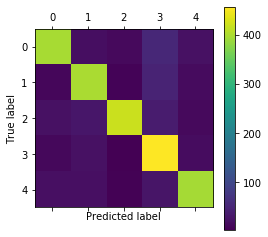

[[0.1588 0.0076 0.0056 0.0212 0.0092]
 [0.0044 0.16   0.0028 0.0192 0.0068]
 [0.0092 0.0124 0.168  0.0148 0.0056]
 [0.0052 0.0092 0.0012 0.1828 0.0072]
 [0.0084 0.0088 0.0024 0.0112 0.158 ]]

Confusion Matrix (normalised)


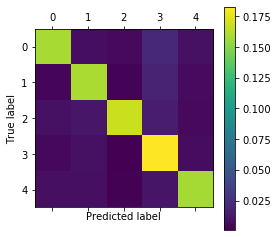

Classification Report

              precision    recall  f1-score   support

           0       0.85      0.78      0.82       506
           1       0.81      0.83      0.82       483
           2       0.93      0.80      0.86       525
           3       0.73      0.89      0.80       514
           4       0.85      0.84      0.84       472

    accuracy                           0.83      2500
   macro avg       0.83      0.83      0.83      2500
weighted avg       0.84      0.83      0.83      2500

Accuracy achieved: 0.8276 ♡♡♡


In [32]:
#*paste plt.show()*
cm = confusion_matrix(test_generator.classes, predicted_class_indices)

print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')
plt.show()


cm2 = confusion_matrix(test_generator.classes, predicted_class_indices, normalize='all')

print(cm2)
plt.matshow(cm2)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix (normalised)')
plt.show()

print('Classification Report\n')
print(classification_report(test_generator.classes, predicted_class_indices))
print('Accuracy achieved:', accuracy_score(test_generator.classes, predicted_class_indices), '\u2661''\u2661''\u2661')

In [33]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 4380.06720995903 seconds ---
